In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta
%matplotlib inline  

In [3]:
n = 5001 # number of observations in the LB
T = 500 # number of submission 
batch = 20 
p_y = 0.5 # prior distribution for y, true labels

In [4]:
# submission matrix. hyper-parameters
Phat_uniform = np.random.rand(n,T)
Phat_beta = np.maximum(np.minimum(beta.rvs(0.5,0.5,size=(n,T)),1-1e-4),1e-4)

In [5]:
def GeneratorFun(batch,Phat,p_y,nStandardScaler=5000):
    # return a simulator for simulating Y and LB-scores
    # nStandardScaler is the number of obs used to standardize score
    n = Phat.shape[0]
    logP = np.log(Phat)
    log1_P = np.log(1-Phat)
    Y = np.random.rand(nStandardScaler,n)>p_y
    score = (np.dot(Y,logP) + np.dot((1-Y),log1_P))/n    
    mean_, std_ = np.mean(score,0), np.std(score,0)
    def Generator():
        Y = np.random.rand(batch,n)>p_y
        score = (np.dot(Y,logP) + np.dot((1-Y),log1_P))/n
        score = (score - mean_)/std_
        return Y.astype(np.float32),score
    return Generator

In [6]:
def batch_extractor(seq_len,n,Y):
    # Generator generates the whole sequence. Have to chop it into seq_len segments for RNN
    # n%seq_len needs to be 1 for this to work. otherwise needs to build a separate RNN graph 
    # with shorter length for static_rnn to work.
    num = int(n/seq_len)
    for i in range(num):
        start,end = i*seq_len,(i+1)*seq_len
        if end >= n:    
            yield Y[:,start:n-1], Y[:,start+1:n]
        else:
            yield Y[:,start:end], Y[:,start+1:end+1]

In [7]:
gen1 = GeneratorFun(batch,Phat_beta,p_y)

In [8]:
y,s = gen1()

In [9]:
y

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  1.,  1.],
       [ 1.,  0.,  1., ...,  1.,  0.,  1.],
       ..., 
       [ 1.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  1.,  1.,  1.]], dtype=float32)

(array([   35.,   143.,   727.,  1741.,  2631.,  2505.,  1514.,   545.,
          136.,    23.]),
 array([-3.4887724 , -2.77689409, -2.06501578, -1.35313747, -0.64125916,
         0.07061915,  0.78249747,  1.49437578,  2.20625409,  2.9181324 ,
         3.63001071]),
 <a list of 10 Patch objects>)

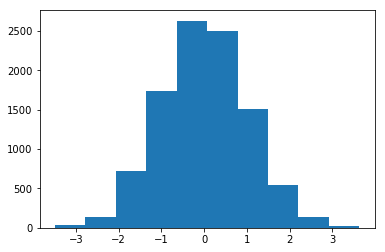

In [10]:
plt.hist(s.flatten())

<br>

Test different model structure.
1. skip connection between the score and every seq_len init via concat 
2. skip connection between the score and every seq_len init via addition
3. no skip connection. Score fed in only at the begining

In [77]:
seq_len = 100
cells_dim = 512
learning_rate = 1e-3
grad_clip = 10.0
epoch = 100

In [78]:
tf.reset_default_graph()

In [79]:
score = tf.placeholder(tf.float32, [batch, T], name='score')
X = tf.placeholder(tf.float32, [batch, seq_len], name='X')
Y = tf.placeholder(tf.float32, [batch, seq_len], name='Y')
keep_prob = tf.placeholder(tf.float32,[])
is_start = tf.placeholder(tf.bool,[])

In [80]:
# embedding = tf.get_variable("embedding", [2, cells_dim],initializer=tf.contrib.layers.xavier_initializer())
# X_embed = tf.nn.relu(tf.nn.embedding_lookup(embedding,X))
# X_list = tf.unstack(X_embed,axis=1)

In [81]:
X_list = tf.split(X,seq_len,axis=1)

In [82]:
cell = tf.contrib.rnn.DropoutWrapper(tf.contrib.rnn.GRUCell(cells_dim),keep_prob)

In [83]:
init_state = cell.zero_state(batch,tf.float32)

In [60]:
# 1.concat score and init
init_state2 = tf.concat([score,init_state],1)
with tf.name_scope('hidden1'):
    weights_h1 = tf.Variable(
        tf.truncated_normal([T+cells_dim, cells_dim],
                            stddev=1.0 / np.sqrt(T+cells_dim)),
        name='weights')
    biases_h1 = tf.Variable(tf.zeros([cells_dim]),
                         name='biases')
    hidden1 = tf.nn.relu(tf.matmul(init_state2, weights_h1) + biases_h1)

with tf.name_scope('hidden2'):
    weights_h2 = tf.Variable(
        tf.truncated_normal([cells_dim, cells_dim],
                            stddev=1.0 / np.sqrt(cells_dim)),
        name='weights')
    biases_h2 = tf.Variable(tf.zeros([cells_dim]),
                         name='biases')
    init_state2 = tf.nn.tanh(tf.matmul(hidden1, weights_h2) + biases_h2) # use tanh to be in the same range as GRU

In [51]:
# 2.add score and init
with tf.name_scope('hidden1'):
    weights_h1 = tf.Variable(
        tf.truncated_normal([T, cells_dim],
                            stddev=1.0 / np.sqrt(T)),
        name='weights')
    biases_h1 = tf.Variable(tf.zeros([cells_dim]),
                         name='biases')
    hidden1 = tf.nn.relu(tf.matmul(score, weights_h1) + biases_h1)

with tf.name_scope('hidden2'):
    weights_h2 = tf.Variable(
        tf.truncated_normal([cells_dim, cells_dim],
                            stddev=1.0 / np.sqrt(cells_dim)),
        name='weights')
    biases_h2 = tf.Variable(tf.zeros([cells_dim]),
                         name='biases')
    hidden2 = tf.nn.tanh(tf.matmul(hidden1, weights_h2) + biases_h2) # use tanh to be in the same range as GRU
    init_state2 = hidden2 + init_state

In [84]:
# 3.no skip connection
def MLP():
    with tf.name_scope('hidden1'):
        weights_h1 = tf.Variable(
            tf.truncated_normal([T, cells_dim],
                                stddev=1.0 / np.sqrt(T)),
            name='weights')
        biases_h1 = tf.Variable(tf.zeros([cells_dim]),
                             name='biases')
        hidden1 = tf.nn.relu(tf.matmul(score, weights_h1) + biases_h1)

    with tf.name_scope('hidden2'):
        weights_h2 = tf.Variable(
            tf.truncated_normal([cells_dim, cells_dim],
                                stddev=1.0 / np.sqrt(cells_dim)),
            name='weights')
        biases_h2 = tf.Variable(tf.zeros([cells_dim]),
                             name='biases')
        hidden2 = tf.nn.tanh(tf.matmul(hidden1, weights_h2) + biases_h2) # use tanh to be in the same range as GRU
    return hidden2
init_state2 = tf.cond(is_start, MLP, lambda: init_state)

In [ ]:
# 3.no skip connection
with tf.name_scope('hidden1'):
    weights_h1 = tf.Variable(
        tf.truncated_normal([T, cells_dim],
                            stddev=1.0 / np.sqrt(T)),
        name='weights')
    biases_h1 = tf.Variable(tf.zeros([cells_dim]),
                         name='biases')
    hidden1 = tf.nn.relu(tf.matmul(score, weights_h1) + biases_h1)

with tf.name_scope('hidden2'):
    weights_h2 = tf.Variable(
        tf.truncated_normal([cells_dim, cells_dim],
                            stddev=1.0 / np.sqrt(cells_dim)),
        name='weights')
    biases_h2 = tf.Variable(tf.zeros([cells_dim]),
                         name='biases')
    hidden2 = tf.nn.tanh(tf.matmul(hidden1, weights_h2) + biases_h2) # use tanh to be in the same range as GRU
init_state2 = tf.cond(is_start, lambda: hidden2, lambda: init_state)

In [85]:
outputs, state = tf.contrib.rnn.static_rnn(cell,X_list,init_state2)

In [86]:
outputs_flat = tf.stack(outputs,1)

In [87]:
with tf.name_scope('prediction'):
    weights_pred = tf.Variable(
        tf.truncated_normal([cells_dim],
                            stddev=1.0 / np.sqrt(cells_dim)),
        name='weights')
    biases_pred = tf.Variable(tf.zeros([1,]),
                         name='biases')

In [88]:
yhat = tf.einsum('blc,c->bl',outputs_flat,weights_pred) + biases_pred

In [89]:
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=Y,logits=yhat))

In [90]:
tvars = tf.trainable_variables()
grads, _ = tf.clip_by_global_norm(tf.gradients(loss, tvars),grad_clip)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.apply_gradients(zip(grads, tvars))

<br>

Build graph for sampling. There are two types of graph, one connected to score, one does not.

In [149]:
input_sample1 = tf.placeholder(tf.int32, [None], name='input_sample')
state_sample1 = tf.placeholder(tf.float32, [None,cells_dim], name='input_sample')

In [385]:
pred_sample1, state_out_sample1 = cell(tf.nn.embedding_lookup(embedding,input_sample1),state_sample1)

In [386]:
pred_sample1 = tf.nn.sigmoid(tf.einsum('bc,c->b',pred_sample1,weights_pred) + biases_pred)

<br>

In [387]:
score_sample2 = tf.placeholder(tf.float32, [None, T], name='score')
input_sample2 = tf.placeholder(tf.int32, [None], name='input_sample')
state_sample2 = tf.placeholder(tf.float32, [None,cells_dim], name='input_sample')

In [388]:
init_sample2 = tf.concat([score_sample2,state_sample2],1)

In [389]:
hidden_sample1 = tf.nn.relu(tf.matmul(init_sample2, weights_h1) + biases_h1)
hidden_sample2 = tf.nn.tanh(tf.matmul(hidden_sample1, weights_h2) + biases_h2)

In [390]:
pred_sample2, state_out_sample2 = cell(tf.nn.embedding_lookup(embedding,input_sample2),hidden_sample2)

In [391]:
pred_sample2 = tf.nn.sigmoid(tf.einsum('bc,c->b',pred_sample2,weights_pred) + biases_pred)

<br>

Training

In [67]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [68]:
# with skip connection
for i in range(epoch):
    init_state_np = np.zeros((batch,cells_dim),dtype=np.float32)
    y_np,score_np = gen1()
    for y0,y1 in batch_extractor(seq_len,n,y_np):
        _,init_state_np = sess.run([train_op,state],\
                                          {score:score_np,X:y0,Y:y1,init_state:init_state_np,keep_prob:1})

    if i%10 == 0:
        init_state_np = np.zeros((batch,cells_dim),dtype=np.float32)
        loss_val = 0
        y_np,score_np = gen1()
        for j,(y0,y1) in enumerate(batch_extractor(seq_len,n,y_np)):
            loss_j,init_state_np = sess.run([loss,state],\
                                              {score:score_np,X:y0,Y:y1,init_state:init_state_np,keep_prob:1})
            loss_val += loss_j
        loss_val /= j   

        print "iteration:{}, Val loss:{}".format(i,loss_val)

iteration:0, Val loss:0.707361155627
iteration:10, Val loss:0.707416309386
iteration:20, Val loss:0.707302420723
iteration:30, Val loss:0.707305762233
iteration:40, Val loss:0.707301184839
iteration:50, Val loss:0.707316014231
iteration:60, Val loss:0.707280253877
iteration:70, Val loss:0.707301166593
iteration:80, Val loss:0.707296322803
iteration:90, Val loss:0.70730457014


In [327]:
# no skip connection
for i in range(epoch):
    init_state_np = np.zeros((batch,cells_dim),dtype=np.float32)
    y_np,score_np = gen1()
    extractor = batch_extractor(seq_len,n,y_np)
    y0,y1 = extractor.next()
    _,init_state_np = sess.run([train_op,state],\
                                      {score:score_np,init_state:init_state_np,X:y0,Y:y1,is_start:True,keep_prob:1})    
    for y0,y1 in extractor:
        _,init_state_np = sess.run([train_op,state],\
                                          {X:y0,Y:y1,score:score_np,\
                                           init_state:init_state_np,keep_prob:1,\
                                          is_start:False})

    if i%10 == 0:
        init_state_np = np.zeros((batch,cells_dim),dtype=np.float32)
        loss_val = 0
        y_np,score_np = gen1()
        extractor = batch_extractor(seq_len,n,y_np)
        y0,y1 = extractor.next()
        loss_j,init_state_np = sess.run([loss,state],\
                                          {score:score_np,X:y0,Y:y1,init_state:init_state_np,\
                                           is_start:True,keep_prob:1})        
        for j,(y0,y1) in enumerate(batch_extractor(seq_len,n,y_np)):
            loss_j,init_state_np = sess.run([loss,state],\
                                              {score:score_np,X:y0,Y:y1,init_state:init_state_np,\
                                               is_start:False,keep_prob:1})
            loss_val += loss_j
        loss_val = loss_val/(j+1)   

        print "iteration:{}, Val loss:{}".format(i,loss_val)

iteration:0, Val loss:0.696341665983


KeyboardInterrupt: 

In [91]:
# no skip connection
for i in range(1):
    init_state_np = np.zeros((batch,cells_dim),dtype=np.float32)
    y_np,score_np = gen1()
    extractor = batch_extractor(seq_len,n,y_np)
    y0,y1 = extractor.next()
    print(sess.run([weights_h1])[0][0,0])
    _,init_state_np = sess.run([train_op,state],\
                                      {score:score_np,init_state:init_state_np,X:y0,Y:y1,is_start:True,keep_prob:1})  
    print(sess.run([weights_h1])[0][0,0])
    for y0,y1 in extractor:
        _,init_state_np = sess.run([train_op,state],\
                                          {X:y0,Y:y1,score:score_np,\
                                           init_state:init_state_np,keep_prob:1,\
                                          is_start:False})
        print(sess.run([weights_h1])[0][0,0])

0.0273087


TypeError: Cannot interpret feed_dict key as Tensor: Tensor Tensor("X:0", shape=(20, 100), dtype=float32) is not an element of this graph.